In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import os.path
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylib.style as pys
import pylib.preprocess as preprocess
import pylib.fit as pyfit
import iminuit
import seaborn as sns
import awkward as ak

from progressbar import progressbar
import re

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

In [229]:
paths = {
    '550': [
        'root://sl10cmd//scan2011/scan2011_tr_ph_fc_e550_v8.root',
        '/store17/petrov/data/kskl20/tr_ph/11/tr_ph_kskl_550_9158.root',
        'root://sl10cmd//sim/tr_ph_run045046_v5.root',
    ],
    '600': [
        'root://sl10cmd//scan2011/scan2011_tr_ph_fc_e600_v8.root',
        '/store17/petrov/data/kskl20/tr_ph/11/tr_ph_kskl_600_9407.root',
        'root://sl10cmd//sim/tr_ph_run045875_v5.root',
    ],
    '925': [
        'root://sl10cmd//scan2011/scan2011_tr_ph_fc_e925_v8.root',
        '/store17/petrov/data/kskl20/tr_ph/11/tr_ph_kskl_925_10796.root',
        '/store17/petrov/data/spool_storage/multi.root',
    ]
}

In [217]:
# for i in progressbar(trs[4:]):
#     tr_ex = uproot.open(i.strip())['tr_ph']
#     h = preprocess.Handler(tr_ex)
#     df_ex = h.get_good_kaons()
#     e = float(re.findall(r'_(\d+.?\d*)_', i.strip())[0])
#     df_ex.to_csv(f'../csv/mc/v7/11/{e:.2f}.csv') #df_ex.iloc[0].ebeam

In [256]:
path_ex, path_mc, path_mlt = paths['600']

In [257]:
tr_ex = uproot.open(path_ex)['tr_ph']
tr_mc = uproot.open(path_mc)['tr_ph']

In [258]:
%%time
h = preprocess.Handler(tr_ex)
df_ex = h.get_good_kaons()

CPU times: user 10 s, sys: 2.81 s, total: 12.8 s
Wall time: 41.5 s


In [259]:
%%time
h = preprocess.Handler(tr_mc)
df_mc = h.get_good_kaons()

CPU times: user 554 ms, sys: 2.19 ms, total: 556 ms
Wall time: 553 ms


In [260]:
def means(dfm):
    dfm['tptot_mean'] = (dfm.tptot_p + dfm.tptot_n)/2
    dfm['tdedx_mean'] = (dfm.tdedx_p + dfm.tdedx_n)/2
    return dfm

In [261]:
# df_ex = means(df_ex)
# df_mc = means(df_mc)

In [262]:
df_ex.head()

,kalign,ksdpsi,ksminv,ksptot,tdedx_n,tdedx_p,tptot_n,tptot_p,trho_n,trho_p,...,tz_p,ebeam,emeas,lumoff,lumofferr,runnum,finalstate_id,badrun,x1,x2
entry,,,,,,,,,,,,,,,,,,,,,
3284,0.877824,2.161435,476.376465,215.108124,2208.063721,2267.772949,253.249985,188.307129,0.024837,-0.016908,...,-1.407769,600.0,598.036987,10.5169,0.196689,9407,0,False,46.346870,-109.097481
7808,0.936655,2.366637,465.408417,274.865601,4429.568359,2458.750488,103.565857,339.106659,-0.017912,-0.004241,...,-3.840138,600.0,598.036987,10.5169,0.196689,9407,0,False,4.347532,-65.196342
7986,0.989351,3.029685,478.891785,272.819336,2957.532715,2956.281494,306.627563,86.702019,0.078951,0.044553,...,-3.886702,600.0,598.036987,10.5169,0.196689,9407,0,False,16.737370,-59.497192
10911,0.982731,2.293348,541.768555,291.530060,2090.791016,2848.727539,376.633820,165.713699,-0.017995,0.027666,...,-0.884550,600.0,598.036987,10.5169,0.196689,9407,0,False,58.990265,-9.314802
12609,0.989034,3.075227,506.592194,129.619034,2220.195801,2656.544922,146.908142,279.732819,-0.136871,-0.173968,...,-0.770576,600.0,598.036987,10.5169,0.196689,9407,0,False,118.566765,-163.921402


In [263]:
# df_ex.to_csv(f'../csv/11/{df_ex.iloc[0].ebeam:.2f}.csv')

In [264]:
# ctr = lambda df, c: df.query(f'(abs(trho_n)>{c})&(abs(trho_p)>{c})&(tptot_p>100)&(tptot_n>100)')
def ctr(df, c, ptot_cut=0):
    return df.query(f'(abs(trho_n)>{c})&(abs(trho_p)>{c})&(tptot_p>{ptot_cut})&(tptot_n>{ptot_cut})')

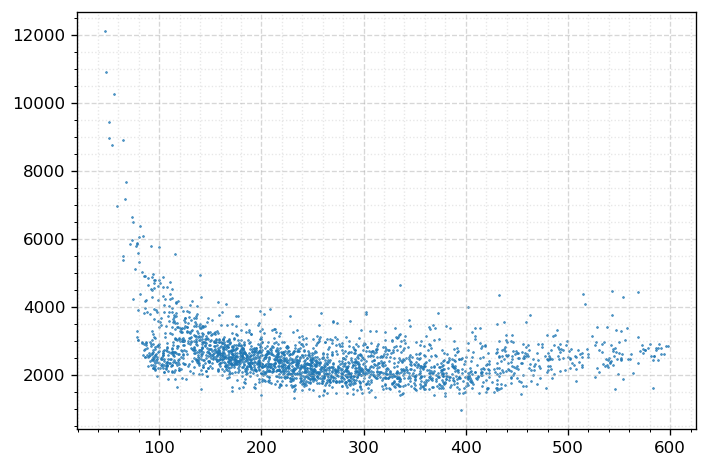

In [265]:
st = 'p'
plt.scatter(ctr(df_ex, 0.0)[f'tptot_{st}'], 
            ctr(df_ex, 0.0)[f'tdedx_{st}'], marker='.', s=1)
# plt.scatter(ctr(df_mc, 0.0)[f'tptot_{st}'], 
#             ctr(df_mc, 0.0)[f'tdedx_{st}'], marker='.', s=1)
pys.my_style()
# plt.xlim(100, 400);

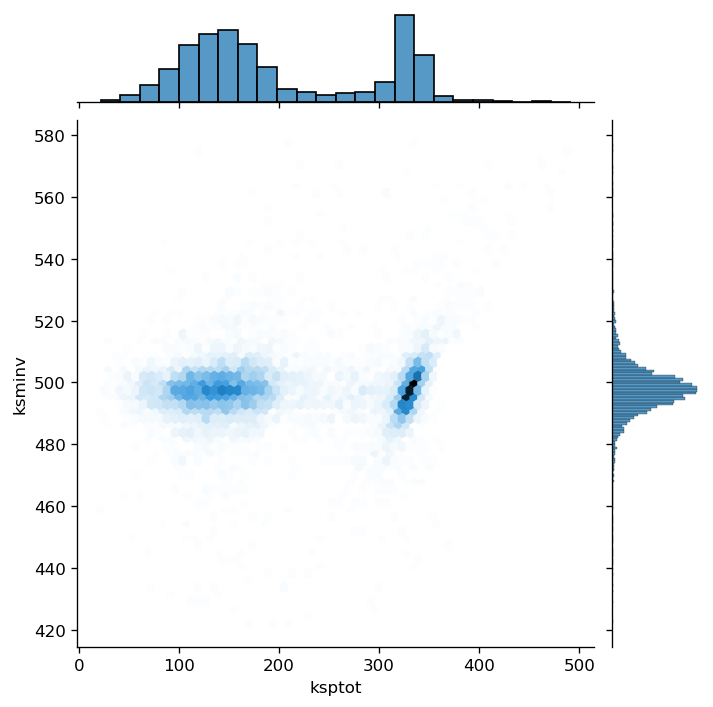

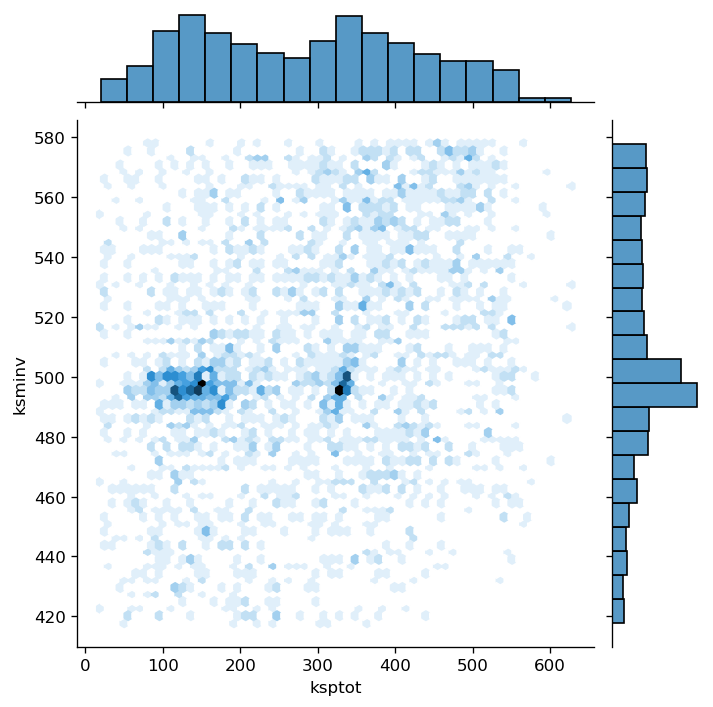

In [266]:
joint = lambda df: sns.jointplot(data=ctr(df, 0.0), 
              x='ksptot', y='ksminv', kind='hex', 
              joint_kws=dict(gridsize=60)
             )
joint(df_mc)
joint(df_ex)

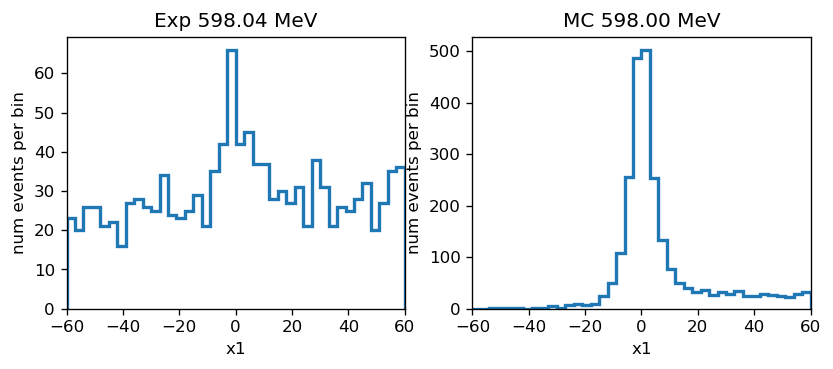

In [267]:
rng = (-60, 60)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.hist(ctr(df_ex, 0.).x1, bins=40, range=rng, histtype='step', lw=2);
ax1.set(title=f'Exp {df_ex.emeas.iloc[0]:.2f} MeV', xlabel='x1', ylabel='num events per bin', xlim=rng);
ax2.hist(ctr(df_mc, 0.).x1, bins=40, range=rng, histtype='step', lw=2);
ax2.set(title=f'MC {df_mc.emeas.iloc[0]:.2f} MeV', xlabel='x1', ylabel='num events per bin', xlim=rng);
# plt.hist(ctr(df_mc, 0.0, 100).x1, bins=100, range=(-40, 40), alpha=0.5);
# plt.hist(ctr(df, 0.0).x1-4, bins=100, range=(-40, 40), alpha=0.5, weights=0.35*np.ones_like(ctr(df, 0.0).x1));

Видно, что хотя пик и виден, но количество фона велико

In [268]:
tr_mlt = uproot.open(path_mlt)['tr_ph']

In [269]:
%%time
h = preprocess.Handler(tr_mlt)
df_mlt = h.get_good_kaons()

CPU times: user 2.93 s, sys: 75.4 ms, total: 3.01 s
Wall time: 2.93 s


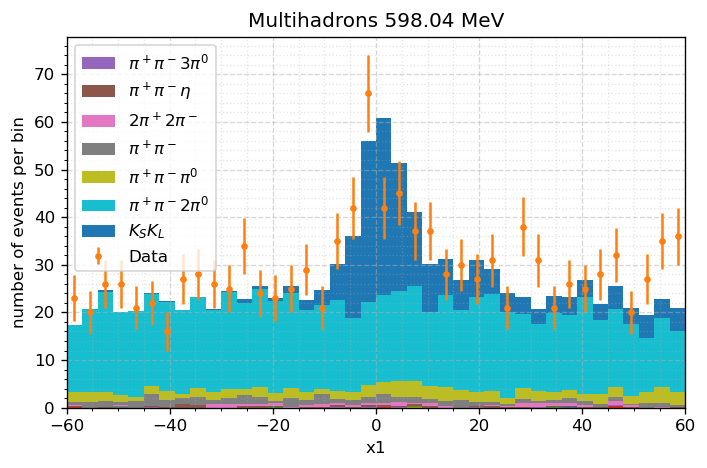

In [291]:
m, bins = 60, 40
r_cut = 0.
d_temp = df_mlt.query(f'abs(x1)<{m}')
final_states = ['$\pi^+\pi^-\pi^0$', '$2\pi^+2\pi^-$', '$\pi^+\pi^-2\pi^0$', '2pi+2pi-pi0', '2pi+2pi-2pi0', '3pi+3pi-',
               'K+K-', '$K_SK_L$', 'K+K-pi0', 'KsK+pi-', 'KlK-pi+', 'K+K-pi+pi-', 'K+K-pi0pi0', 'KlKspi+pi-', 'K+KSpi-pi0',
               '$K^-K^0\pi^+\pi^0$', 'KLKSpi0pi0', '$\pi^+\pi^-$', 'ppbar', 'nnbar', '$\pi^+\pi^-\eta$', 'KsK-pi+', 'KlK+pi-', '$\pi^+\pi^-3\pi^0$', 
               'pi+pi-4pi0', 'KsKspi+pi-', '$\pi^0\gamma$', '$\eta\gamma$']
plt.figure()
processes = np.array( list(d_temp.query('finalstate_id!=8').finalstate_id.value_counts().sort_values(ascending=True).index) + [8] )
dat, ws = [], []
for process in processes:
    dat.append( ctr(d_temp.query(f'finalstate_id=={process}'), r_cut).x1 )
    ws.append( np.ones_like(dat[-1])*len(df_ex.query('abs(x1)<20'))/len(d_temp.query('abs(x1)<20')) )
labs = np.array(final_states)[processes-1]
labs[:-7] = '_nolegend_'
plt.hist(dat, bins=bins, range=(-m, m), stacked=True, label=labs, alpha=1, histtype='bar', lw=2,
        weights=ws)
pys.hep_histo(ctr(df_ex, r_cut).x1, bins=bins, range=(-m, m), label='Data', roll_bins=0)
pys.my_style(title=f'Multihadrons {d_temp.iloc[0].emeas:.2f} MeV', xtitle='x1', ytitle='number of events per bin', xlim=(-m, m), legend=True);

Понятно, что фон усложняет жизнь без отбора по $\rho$

$4 \pi$

In [357]:
# df_4p = ak.to_pandas(tr_mlt.arrays(['trho', 'tth', 'tdedx', 'tptot'], 
#                            f'(nt==2)&(tth>0.8)&(tth<{np.pi-0.8})&(tnhit>12)&(abs(trho)<0.2)&(abs(pidedx)<2000)&(tchi2r<25)&(tchi2z<25)',
#                            aliases={'pidedx': '5.58030e+9 / (tptot + 40.)**3 + 2.21228e+3 - 3.77103e-1 * tptot - tdedx'}))
# d0 = ak.to_pandas(tr_mlt.arrays(['finalstate_id', 'emeas', 'ebeam']))
# d1 = ak.to_pandas(tr_mlt.arrays(['phen'], '(nt==2)')).groupby('entry').agg(en=('phen', 'sum'))
# d1 = d1.loc[d1.en<40]
# d1 = d1.append(ak.to_pandas(tr_mlt.arrays(['nph'], '(nt==2)&(nph==0)')).rename({'nph': 'en'}, axis=1))
# df_4p = df_4p.reset_index().set_index('entry').loc[df_4p.groupby('entry').agg(num=('trho', 'count')).num==2]\
#                 .join(d0, how='inner').join(d1, how='inner')

Fitting

In [93]:
SEASON = '11'
MC = 'v7'
N_MC = 20000

In [94]:
exp_path_pattern = lambda SEASON, file: f'../csv/{SEASON}/{file}'
mc_path_pattern = lambda SEASON, MC, file: f'../csv/mc/{MC}/{SEASON}/{file}'

In [95]:
exps = os.listdir(exp_path_pattern(SEASON, ''))
mcs = os.listdir(mc_path_pattern(SEASON, MC, ''))
files = sorted(list(set(mcs) & set(exps)))

In [96]:
file = files[0]

In [97]:
exp_file = exp_path_pattern(SEASON, file)
mc_file = mc_path_pattern(SEASON, MC, file)

In [98]:
exp_df = pd.read_csv(exp_file, index_col='entry')
mc_df = pd.read_csv(mc_file, index_col='entry')

In [99]:
def mom_constraints(ebeam, res=0.1):
    mk, mpi = 497.6, 139.6 #MeV
    V = np.sqrt( 1 - (mk/ebeam)**2)
    E0 = mk/2
    p0 = np.sqrt(E0**2 - mpi**2)
    pmin, pmax = (E0 - V*P0)/np.sqrt(1 - V**2), (E0 + V*P0)/np.sqrt(1 - V**2)
    return (pmin*(1-res), pmax*(1+res))

def mom_cut(df, res=0.1):
    cut1 = (df['tptot_p'] > mom_constraints(df.emeas, res)[0]) & (df['tptot_p'] < mom_constraints(df.emeas, res)[1])
    cut2 = (df['tptot_n'] > mom_constraints(df.emeas, res)[0]) & (df['tptot_n'] < mom_constraints(df.emeas, res)[1])
#     cut3 = (df['tptot_p'] + df['tptot_n']) < 550
    return df.loc[cut1 & cut2]

In [100]:
# exp_df = mom_cut(exp_df)
# mc_df = mom_cut(mc_df)

In [101]:
exp_df.head()

,kalign,ksminv,ksptot,tdedx_n,tdedx_p,tptot_n,tptot_p,trho_n,trho_p,tz_n,...,emeas,lumoff,lumofferr,runnum,finalstate_id,badrun,x1,x2,tptot_mean,tdedx_mean
entry,,,,,,,,,,,,,,,,,,,,,
1796,0.835022,494.81860,434.11176,3258.2893,2579.7693,176.555820,407.96988,-0.018087,-0.039569,0.487827,...,548.44,7.81239,0.161432,9158,0,False,-133.50827,153.61154,292.26285,2919.0293
3494,0.997347,494.36475,126.51439,3347.3801,2486.4450,155.663880,265.32460,0.269219,-0.168770,-3.087238,...,548.44,7.81239,0.161432,9158,0,False,64.73462,-81.58219,210.49423,2916.9126
4343,0.988489,541.52030,429.01236,2348.3962,3206.8710,251.138320,437.45712,0.019144,0.067233,-2.670847,...,548.44,7.81239,0.161432,9158,0,False,-94.55164,179.86867,344.29773,2777.6338
6611,0.821608,485.49710,344.34122,2528.2986,3272.0974,357.730870,159.39233,0.002215,0.013758,-4.183397,...,548.44,7.81239,0.161432,9158,0,False,-82.66955,79.03900,258.56158,2900.1980
11900,0.997950,537.80710,333.87720,3766.3184,3710.3100,106.093376,442.63757,-0.021377,-0.059301,1.278828,...,548.44,7.81239,0.161432,9158,0,False,-35.96659,104.82016,274.36548,3738.3142


In [102]:
exp_df.columns

Index(['kalign', 'ksminv', 'ksptot', 'tdedx_n', 'tdedx_p', 'tptot_n',
       'tptot_p', 'trho_n', 'trho_p', 'tz_n', 'tz_p', 'ebeam', 'emeas',
       'lumoff', 'lumofferr', 'runnum', 'finalstate_id', 'badrun', 'x1', 'x2',
       'tptot_mean', 'tdedx_mean'],
      dtype='object')

In [103]:
exp_df['tptot_sum'] = exp_df['tptot_p'] + exp_df['tptot_n']
mc_df['tptot_sum'] = mc_df['tptot_p'] + mc_df['tptot_n']

In [104]:
exp_df['tdedx_sum'] = exp_df['tdedx_p'] + exp_df['tdedx_n']
mc_df['tdedx_sum'] = mc_df['tdedx_p'] + mc_df['tdedx_n']

In [105]:
exp_df['trho_sum'] = exp_df['trho_p'] + exp_df['trho_n']
mc_df['trho_sum'] = mc_df['trho_p'] + mc_df['trho_n']

In [106]:
exp_df['tz_sum'] = exp_df['tz_p'] + exp_df['tz_n']
mc_df['tz_sum'] = mc_df['tz_p'] + mc_df['tz_n']

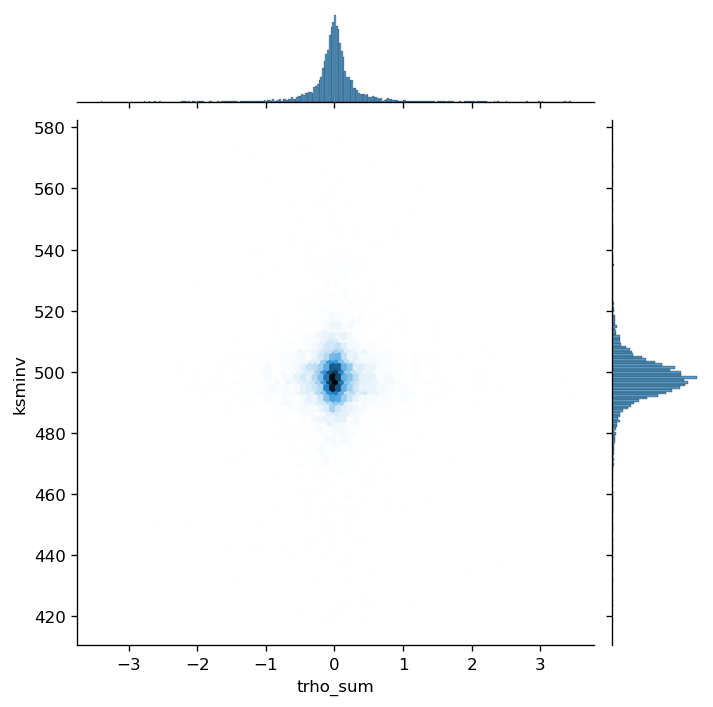

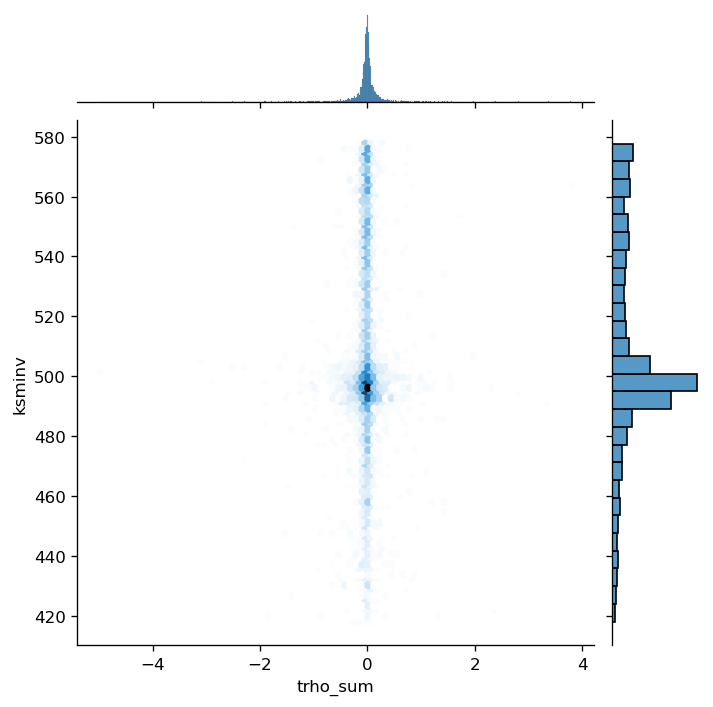

In [107]:
joint = lambda df: sns.jointplot(data=df, 
              x='trho_sum', y='ksminv', kind='hex',
              joint_kws=dict(gridsize=80))
joint(mc_df)
joint(exp_df)

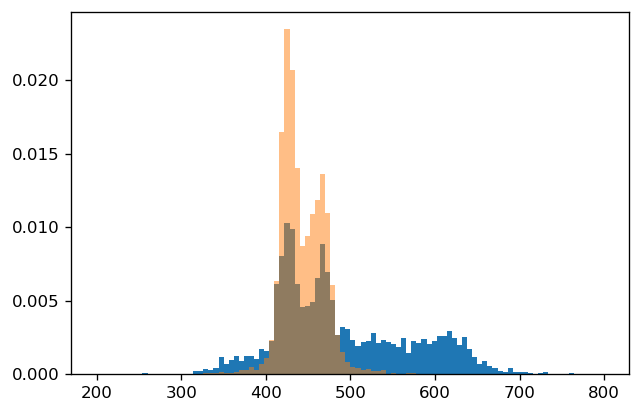

In [108]:
rng = (200, 800)
col = 'tptot_sum'
plt.hist(exp_df[col], density=True, bins=100, range=rng);
plt.hist(mc_df[col], density=True, bins=100, range=rng, alpha=0.5);

In [109]:
fit_range = (-40, 40)
hist_range = (-60, 60)
width = fit_range[1] - fit_range[0]

pars = {
    'n_sig' : 2000,
    'm' : 0,
    'sL' : 2,
    'sR' : 5,
    'aL' : 0,
    'aR' : 0,
    'y0' : 0.1,
    'dy' : 0.1,
    'x0' : -45,
}

lims = {
    'n_sig' : (0, None),
    'm' : (-10, 10),
    'sL' : (1, None),
    'sR' : (1, None),
    'aL' : (0, None),
    'aR' : (0, None),
    'y0' : (0, 0),
    'dy' : (0, 0),
    'x0' : (-40, -40),
}

In [110]:
f1 = pyfit.Fit1(fit_range)

In [111]:
e0 = exp_df.emeas.mean()

In [123]:
dataE, dataM = exp_df.x1.values, mc_df.x1.values

f_mc = pyfit.Fitter(dataM, f1, pars, lims, fit_range)
f_mc.fit()

pars_mc = f_mc.get_params()
lims_mc = f_mc.get_limits(5, ['sL', 'sR', 'aL', 'aR'], 
                          {'y0': (0, None), 'dy': (-4.35, None), 'x0': (None, fit_range[0]), })
sigm_mc = f_mc.get_sigmas(exclude=['n_sig', 'm', 'y0', 'dy', 'x0'])

f_exp = pyfit.Fitter(dataE, f1, pars_mc, lims_mc, fit_range, sigm_mc)
f_exp.fit()

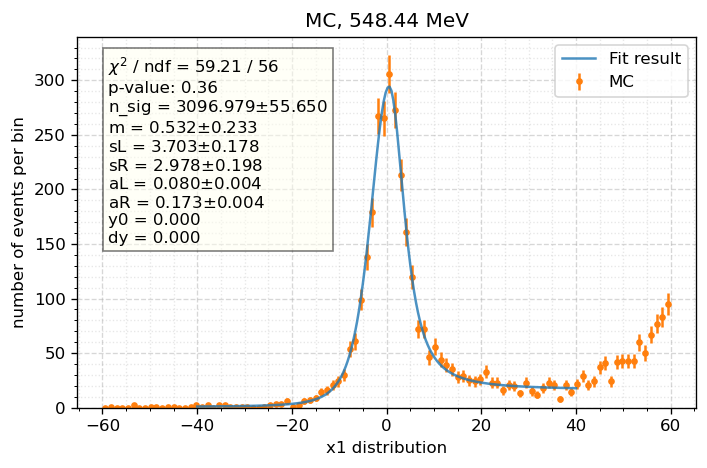

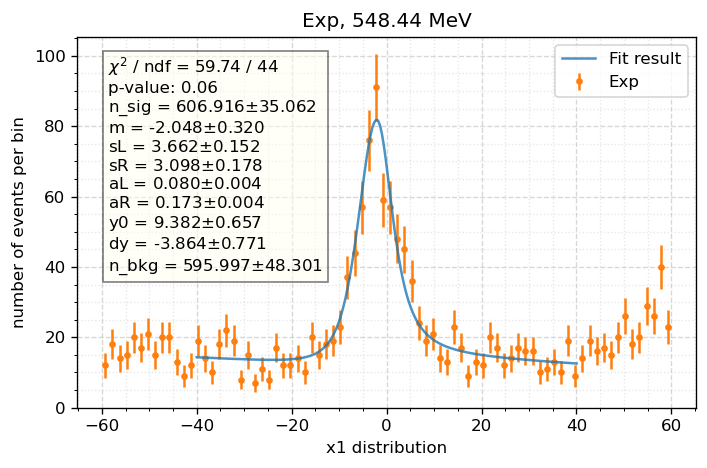

In [124]:
f_mc.plot(hist_range, 100, f'MC, {e0:.2f} MeV', 'MC', 'x1 distribution', 
       'number of events per bin', fill_errors=False)
f_exp.plot(hist_range, 80, f'Exp, {e0:.2f} MeV', 'Exp', 'x1 distribution', 
       'number of events per bin', fill_errors=False)